# Prepare H2O and data

In [1]:
import h2o
h2o.init(max_mem_size = "300G")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_352"; OpenJDK Runtime Environment (build 1.8.0_352-8u352-ga-1~20.04-b08); OpenJDK 64-Bit Server VM (build 25.352-b08, mixed mode)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptd_0thvc
  JVM stdout: /tmp/tmptd_0thvc/h2o_root_started_from_python.out
  JVM stderr: /tmp/tmptd_0thvc/h2o_root_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_root_9zrzj4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,266.6 Gb
H2O_cluster_total_cores:,96
H2O_cluster_allowed_cores:,96
H2O_cluster_status:,"locked, healthy"


In [2]:
import pandas as pd
from utils import Timer

def cutomizedCoordinationFix(df):
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    df = df.drop(columns=['rev'])
    return df

def clean_df(df):    
    #reverse incorrectly assigned longitude/latitude values
    df = cutomizedCoordinationFix(df)
    df = df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]
    
    return df

cols = [
    'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
]

data_path = "../data"

with Timer(f"Load train full"):
    train_data = pd.read_csv(f"{data_path}/train.csv", usecols=cols)

with Timer("Data Wrangling for train"):
    train_data = clean_df(train_data)

with Timer("split train and test"):
    test_sample = train_data.sample(frac = 0.1)
    train_sample = train_data.drop(test_sample.index)

with Timer("convert to h2o frame"):
    h2o_train_data = h2o.H2OFrame(train_sample)

Load train full took 61.794729760847986 sec
Data Wrangling for train took 10.832580755464733 sec
split train and test took 11.758613688871264 sec
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
convert to h2o frame took 295.29033797234297 sec


# Run H2O autoML

In [3]:
from h2o.automl import H2OAutoML

x = h2o_train_data.columns
y = "fare_amount"

aml = H2OAutoML()
with Timer("h2o automl train"):
    aml.train(y=y, training_frame=h2o_train_data)

AutoML progress: |
17:33:07.342: _train param, Dropping bad and constant columns: [pickup_datetime]

███████████████████
17:50:23.767: _train param, Dropping bad and constant columns: [pickup_datetime]

█
17:51:03.951: _train param, Dropping bad and constant columns: [pickup_datetime]

████████
17:58:46.126: _train param, Dropping unused columns: [pickup_datetime]


17:58:58.951: _train param, Dropping bad and constant columns: [pickup_datetime]

██████
18:05:02.375: _train param, Dropping bad and constant columns: [pickup_datetime]

████
18:08:53.723: _train param, Dropping bad and constant columns: [pickup_datetime]

█████
18:13:35.377: _train param, Dropping bad and constant columns: [pickup_datetime]

█████
18:18:30.868: _train param, Dropping bad and constant columns: [pickup_datetime]

█████
18:23:45.976: _train param, Dropping unused columns: [pickup_datetime]


18:23:59.338: _train param, Dropping unused columns: [pickup_datetime]


18:24:11.905: _train param, Dropping bad and 

In [4]:
with Timer("convert test to h2o frame"):
    h2o_test_data = h2o.H2OFrame(test_sample)

with Timer("predict test with h2o model"):
    preds = aml.predict(h2o_test_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
convert test to h2o frame took 46.62095068767667 sec
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
predict test with h2o model took 0.4911598963662982 sec


In [5]:
preds.as_data_frame()

,predict
0,10.705033
1,9.722194
2,8.029529
3,5.850159
4,5.805353
...,...
5431591,8.293963
5431592,6.353699
5431593,10.148346
5431594,6.732412


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

y_val = test_sample["fare_amount"].to_numpy()
pred_val = preds.as_data_frame()['predict'].to_numpy()
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
print('LightGBM RMSE', rmse)

LightGBM RMSE 5.410348011227991


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20221205_173307,5.41035,29.2719,2.82989,0.305056,29.2719,12559,5.1e-05,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20221205_173307,5.41035,29.2719,2.82989,0.305056,29.2719,12808,4e-05,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20221205_173307,5.41035,29.2719,2.82989,0.305056,29.2719,13351,4.9e-05,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20221205_173307,5.41038,29.2722,2.8299,0.305052,29.2722,13752,0.000386,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20221205_173307,5.41038,29.2722,2.8299,0.305052,29.2722,27856,0.000205,StackedEnsemble
XGBoost_1_AutoML_1_20221205_173307,6.00942,36.1131,3.25771,0.334191,36.1131,197671,2.5e-05,XGBoost
XGBoost_2_AutoML_1_20221205_173307,8.41003,70.7286,5.46771,0.594894,70.7286,80278,2.3e-05,XGBoost
GBM_1_AutoML_1_20221205_173307,8.64312,74.7036,5.4261,nan,74.7036,64967,0.000556,GBM
GBM_4_AutoML_1_20221205_173307,8.6785,75.3164,5.45632,nan,75.3164,42414,0.000385,GBM
GBM_2_AutoML_1_20221205_173307,8.69319,75.5715,5.46318,0.541601,75.5715,35788,0.000804,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

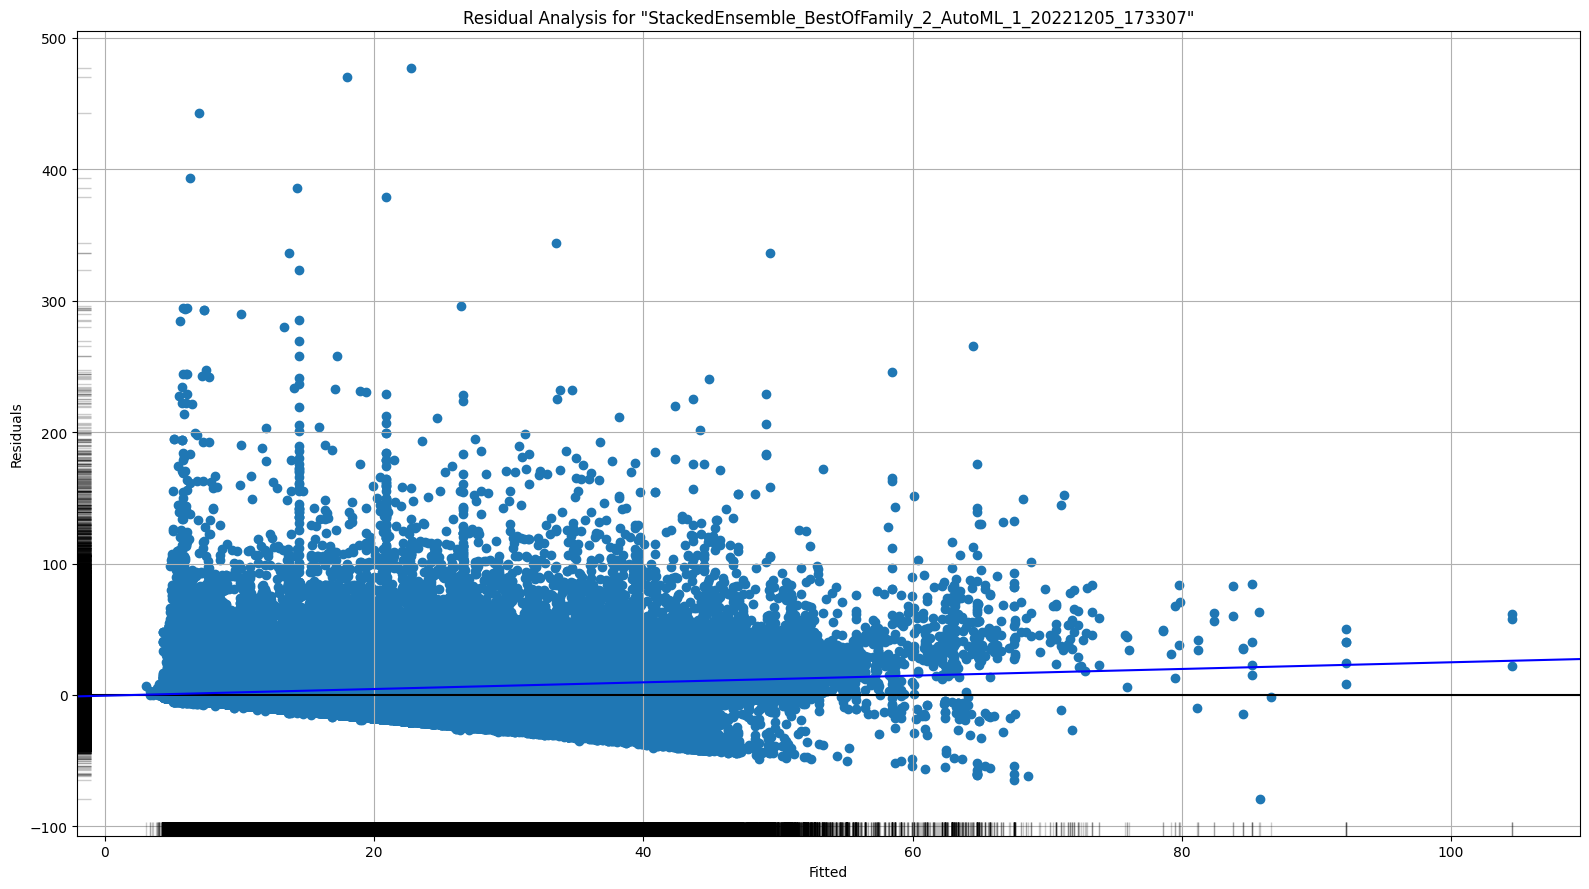

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

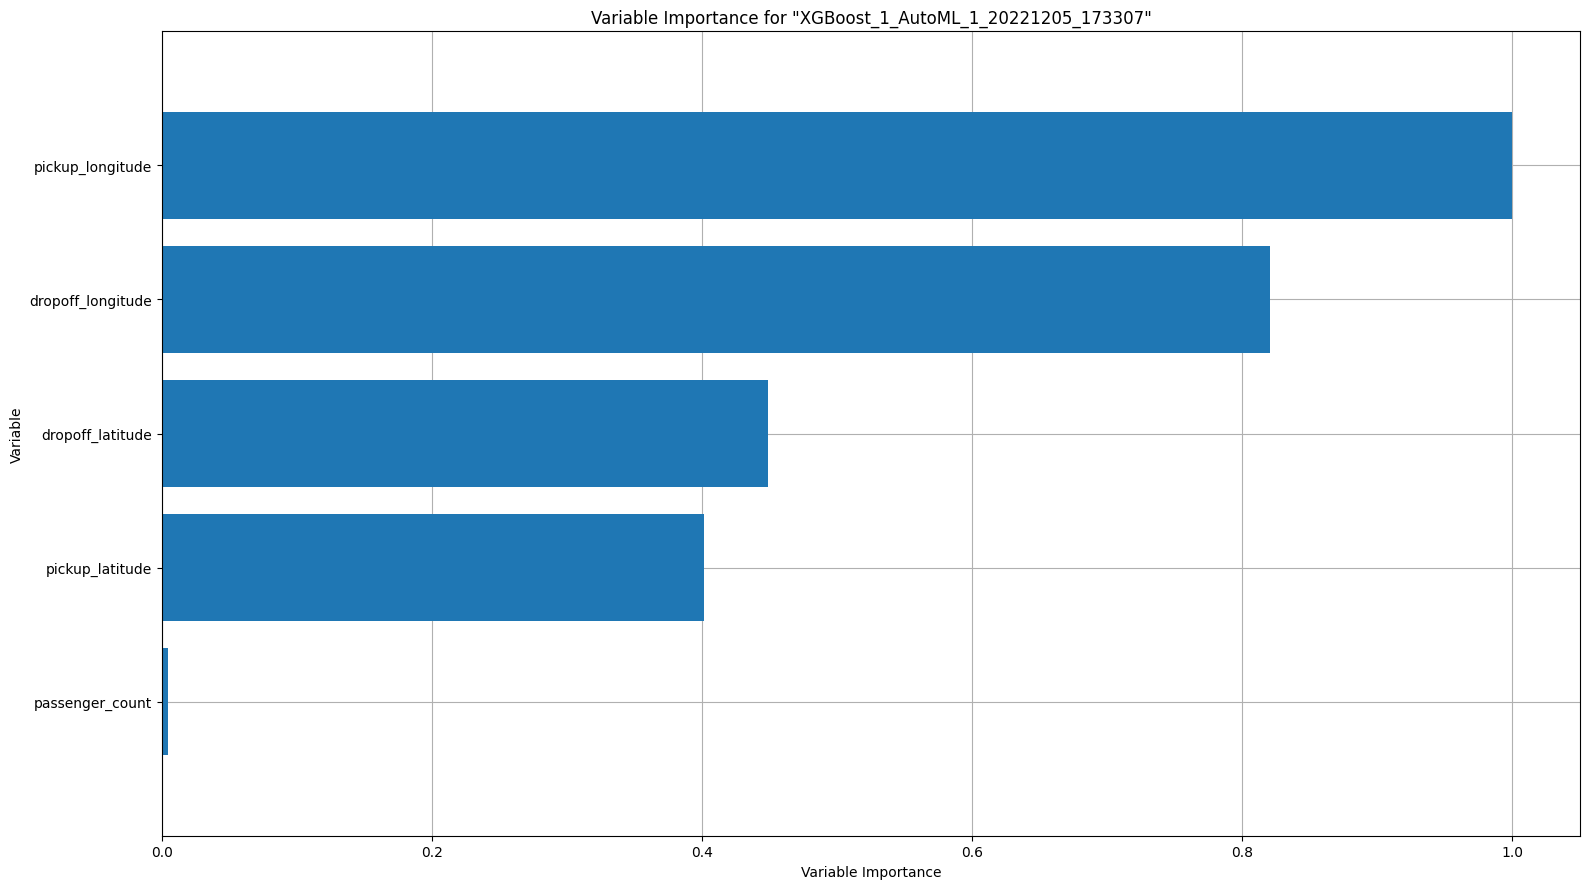

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

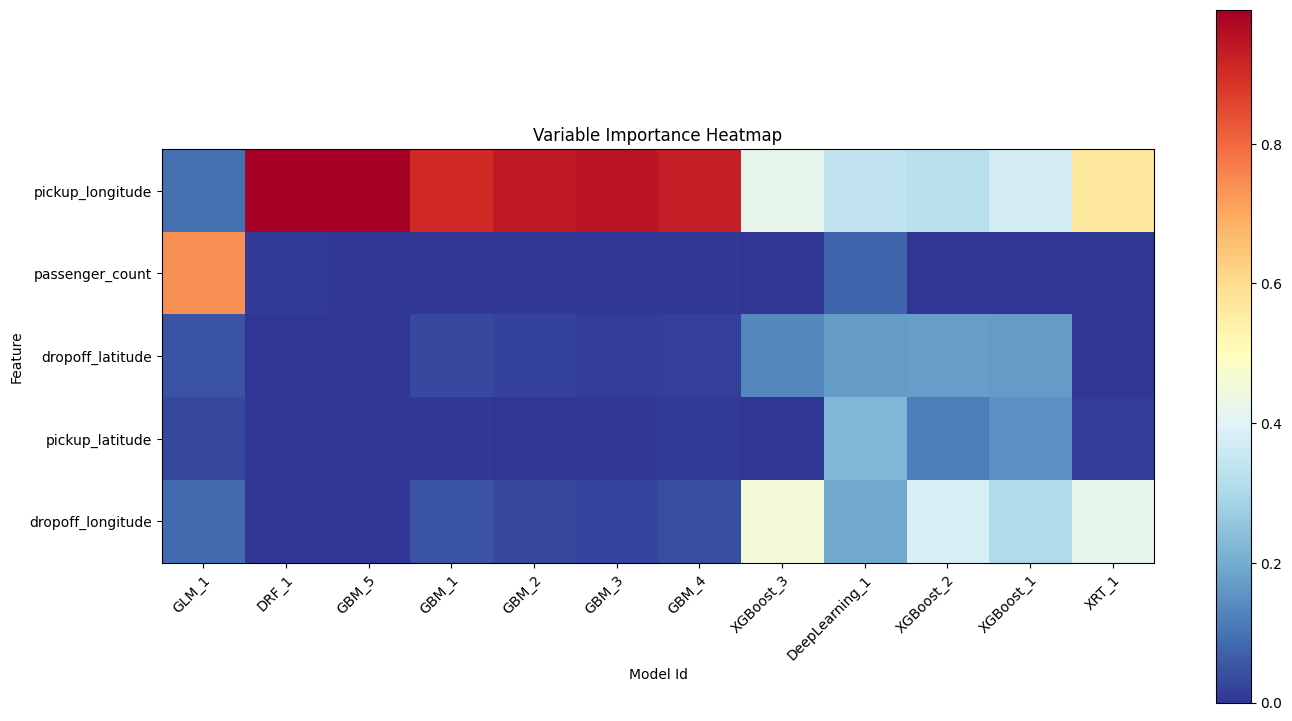

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

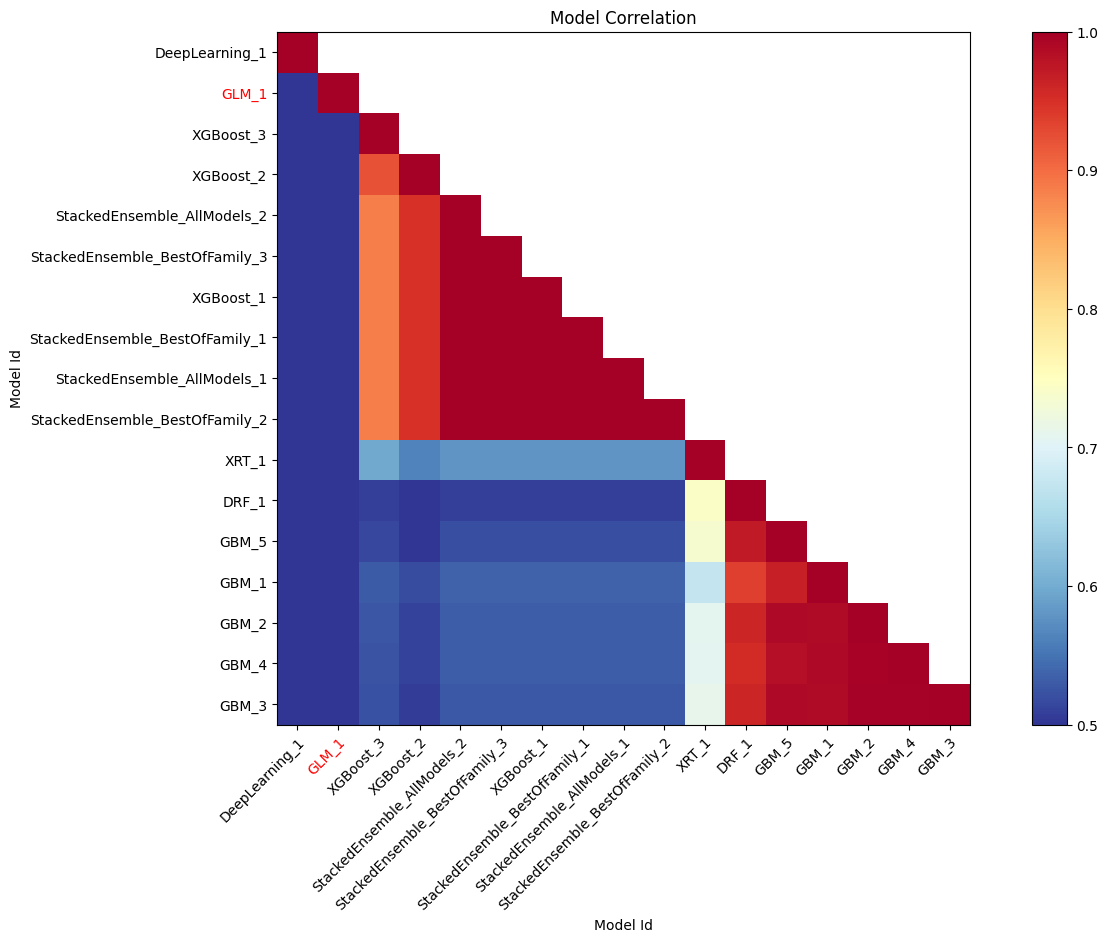

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

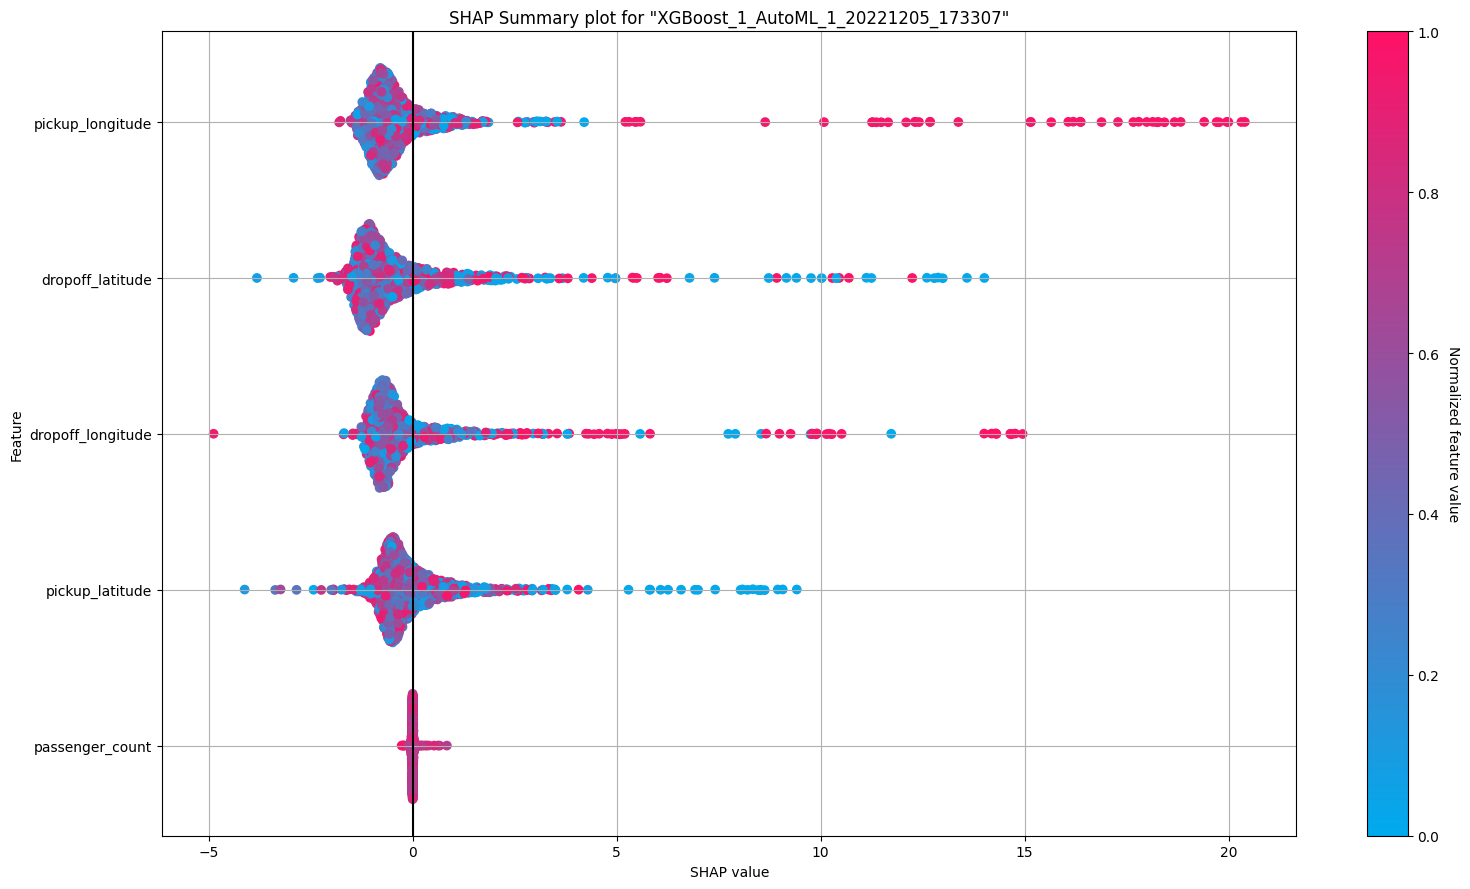

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

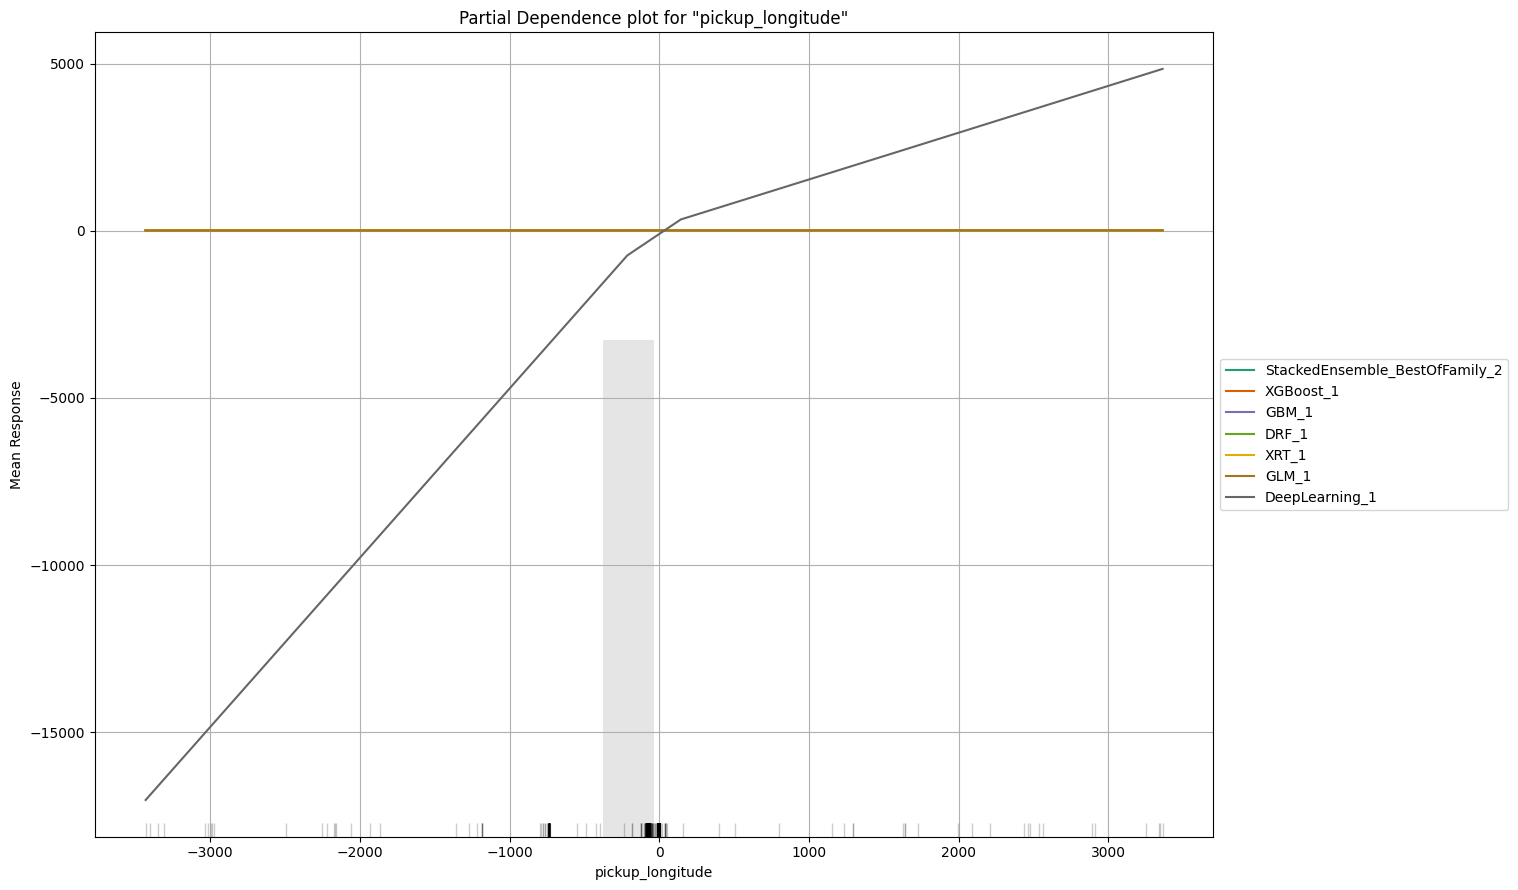

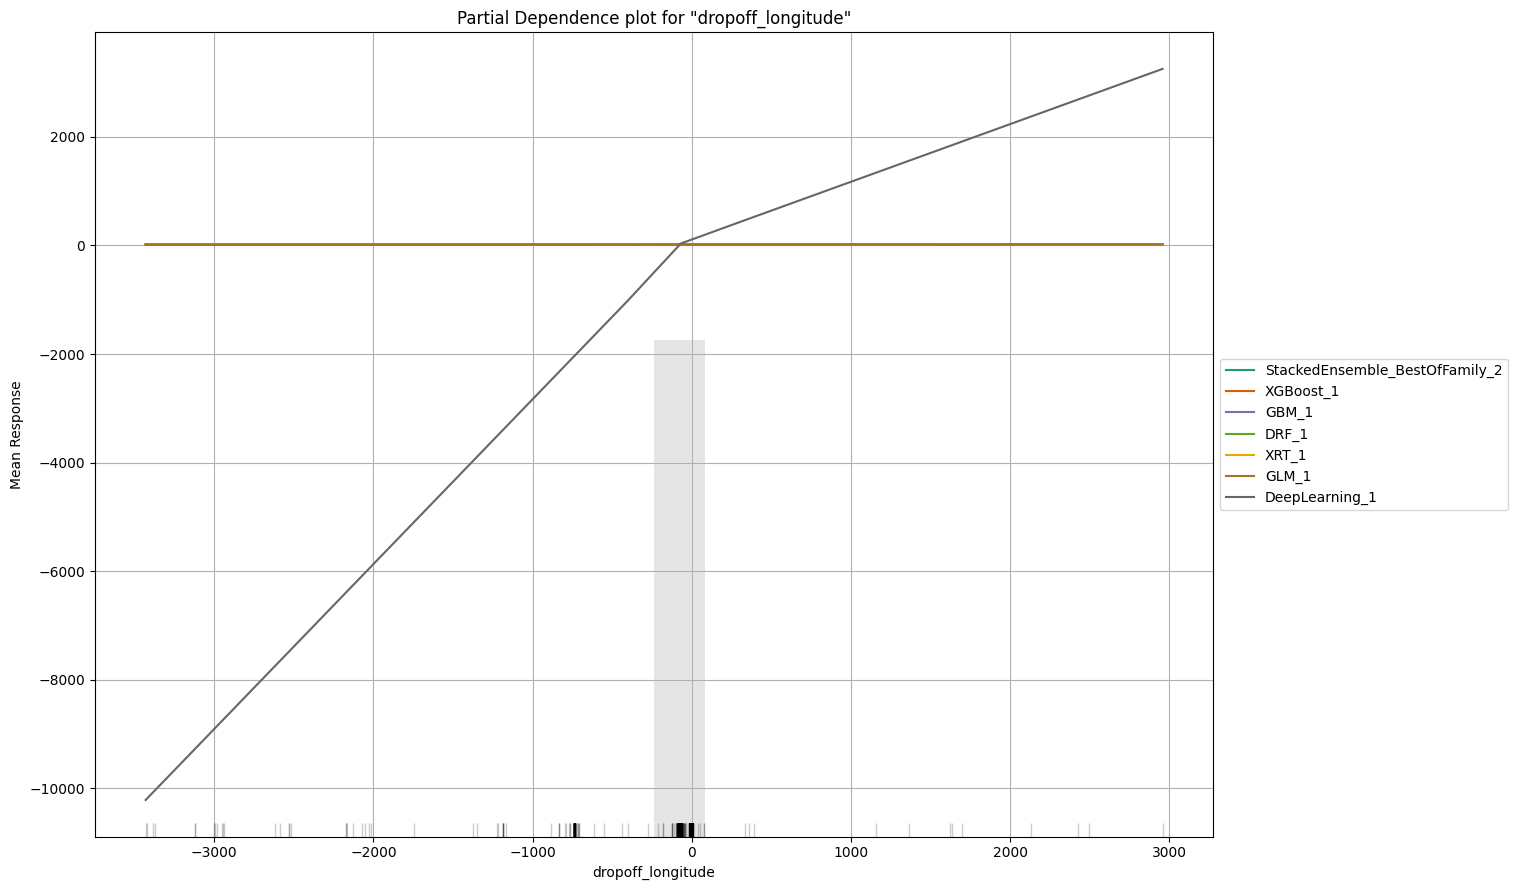

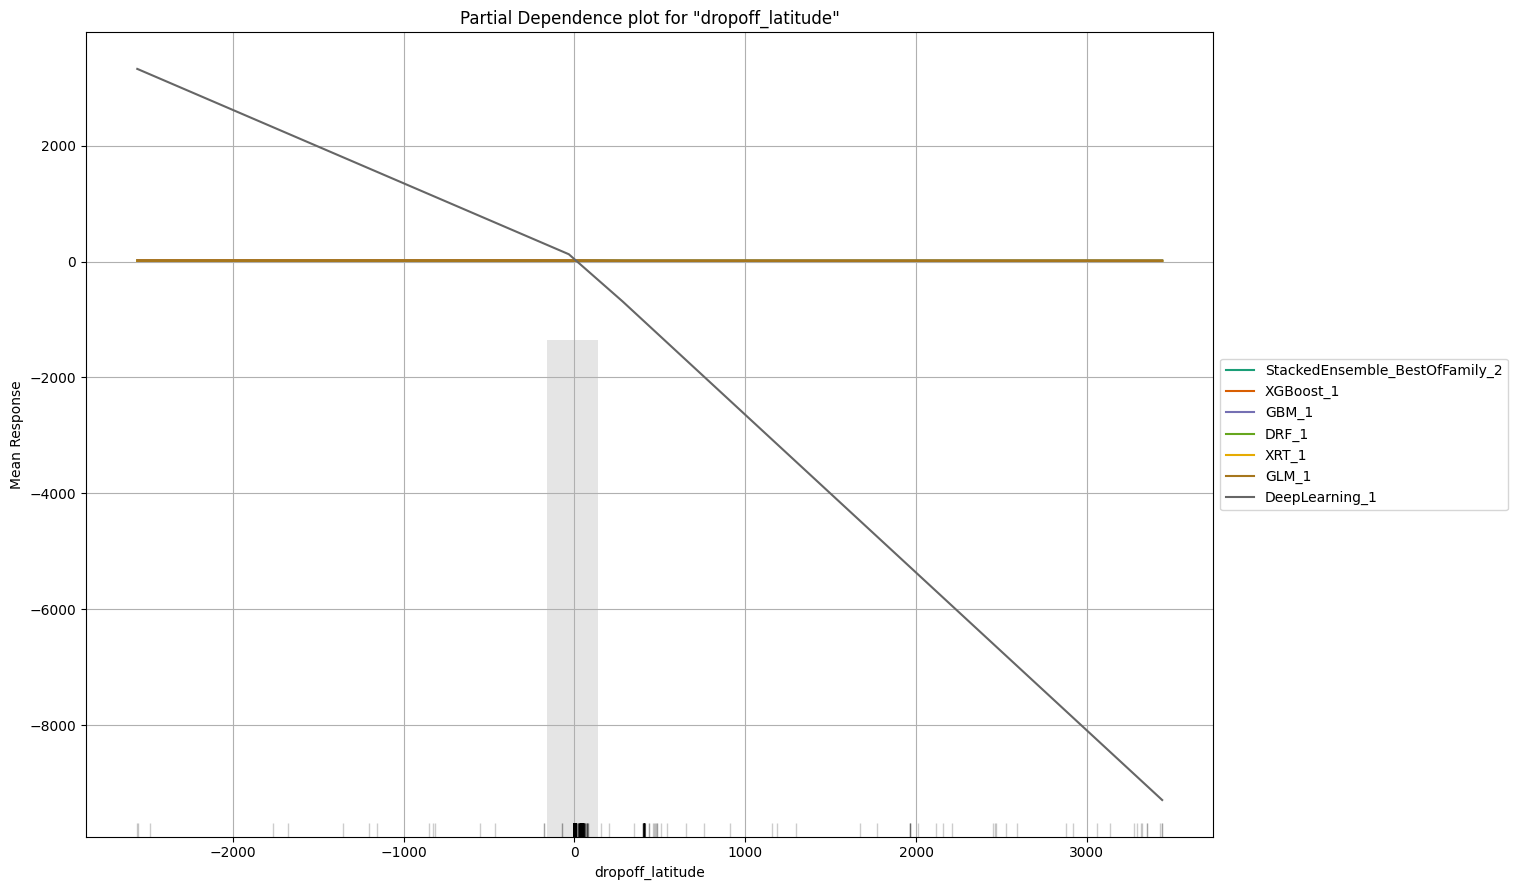

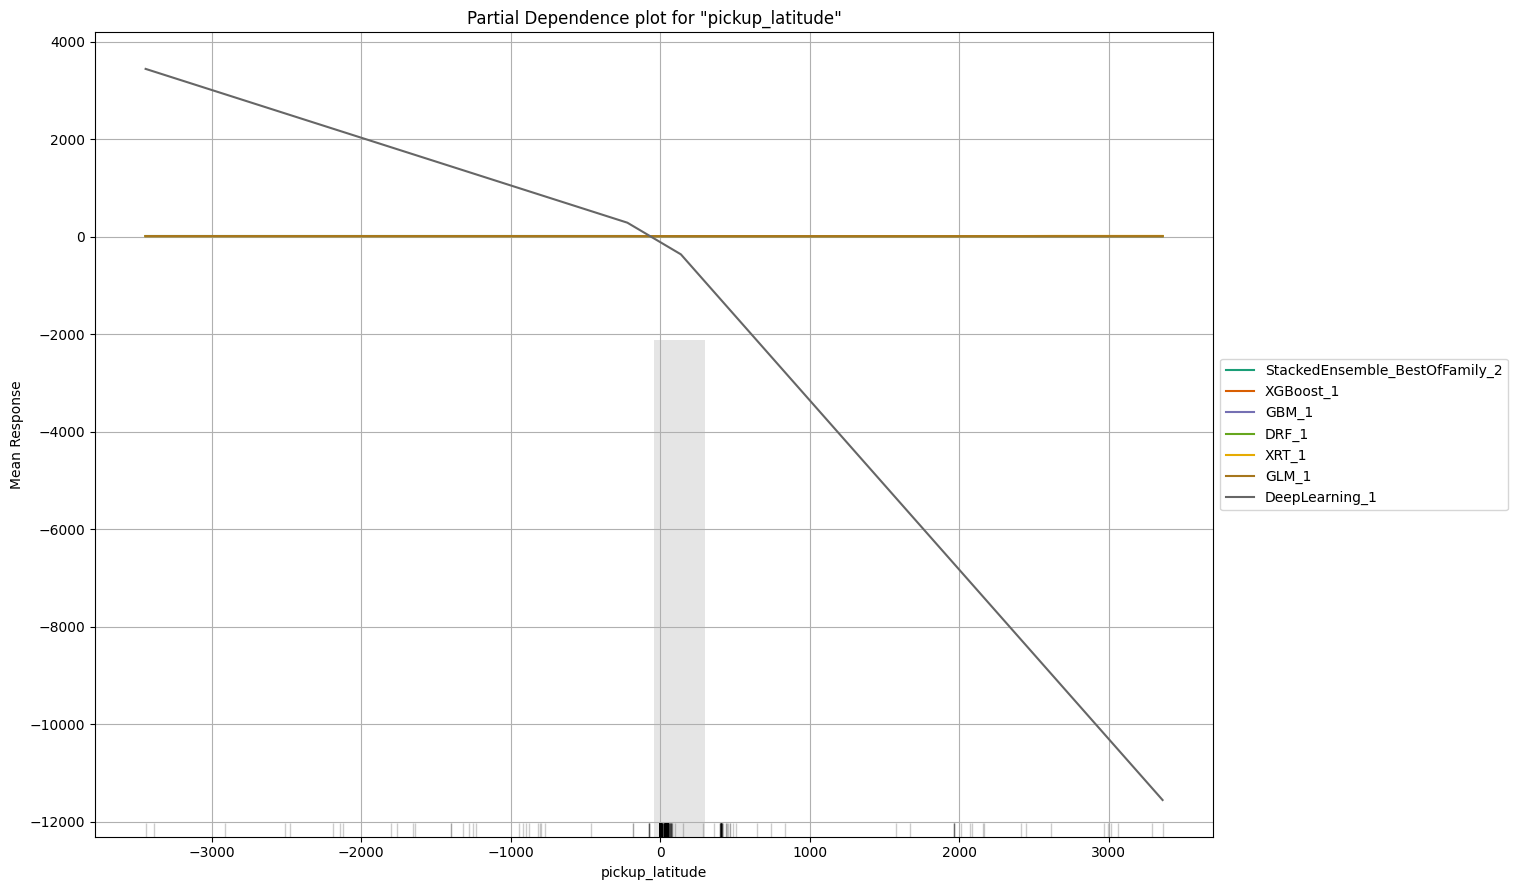

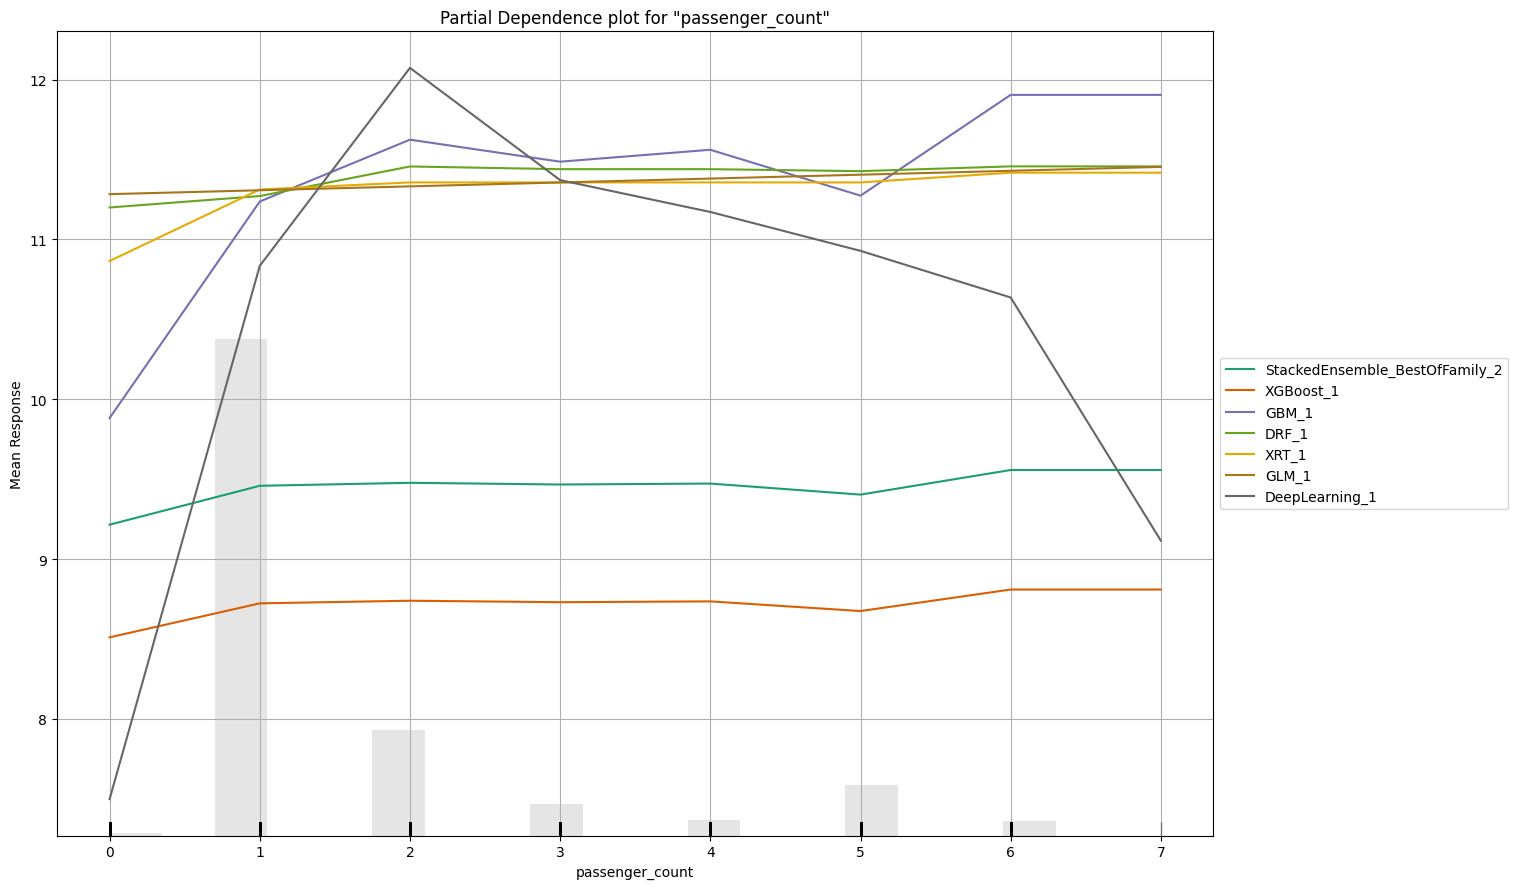

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

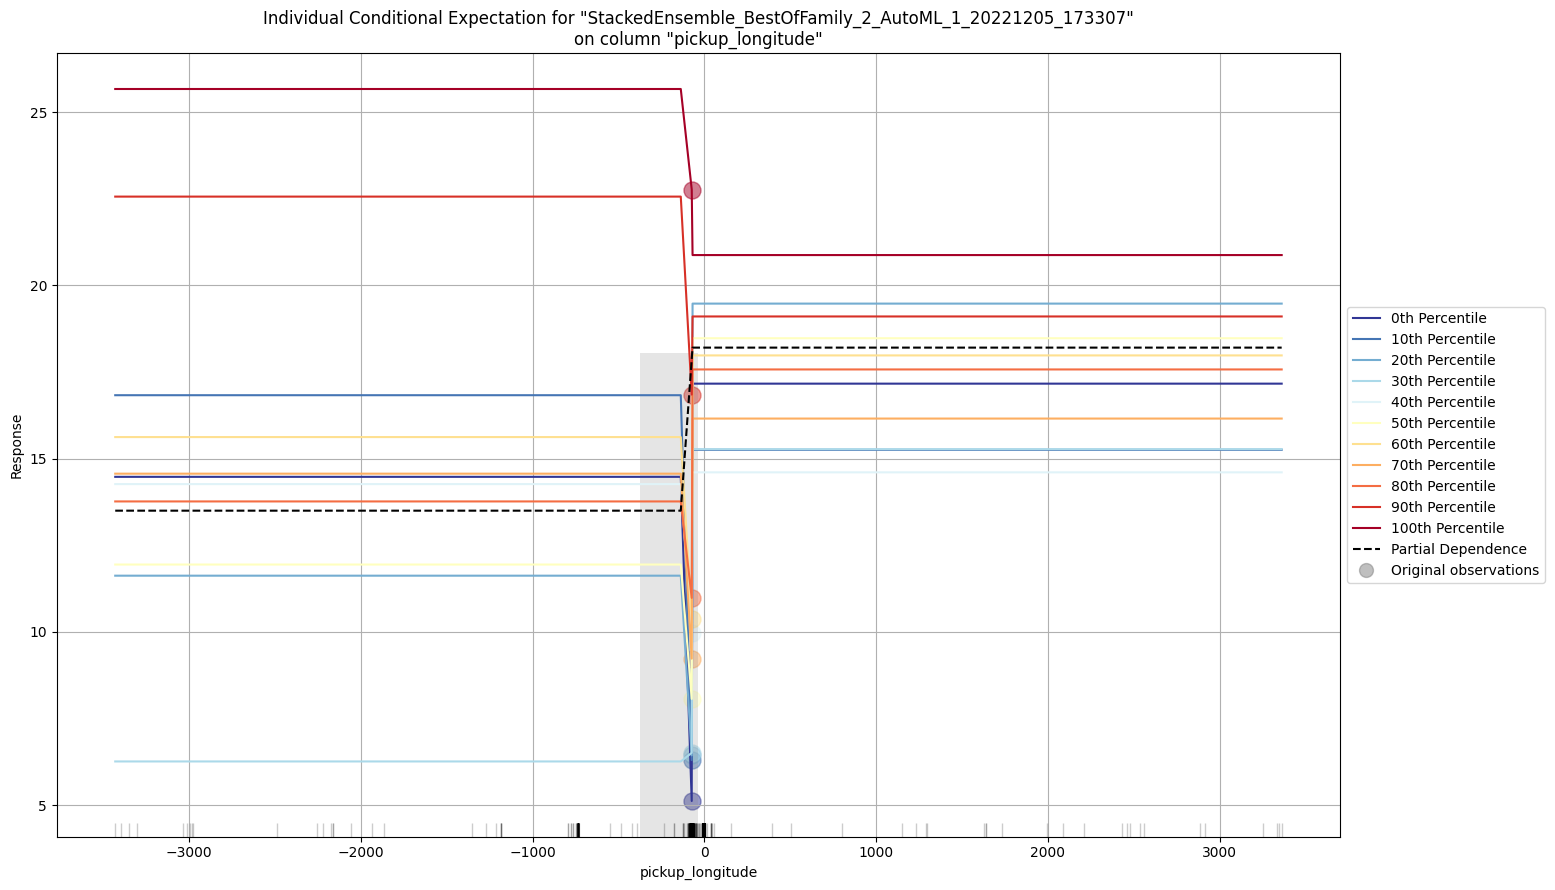

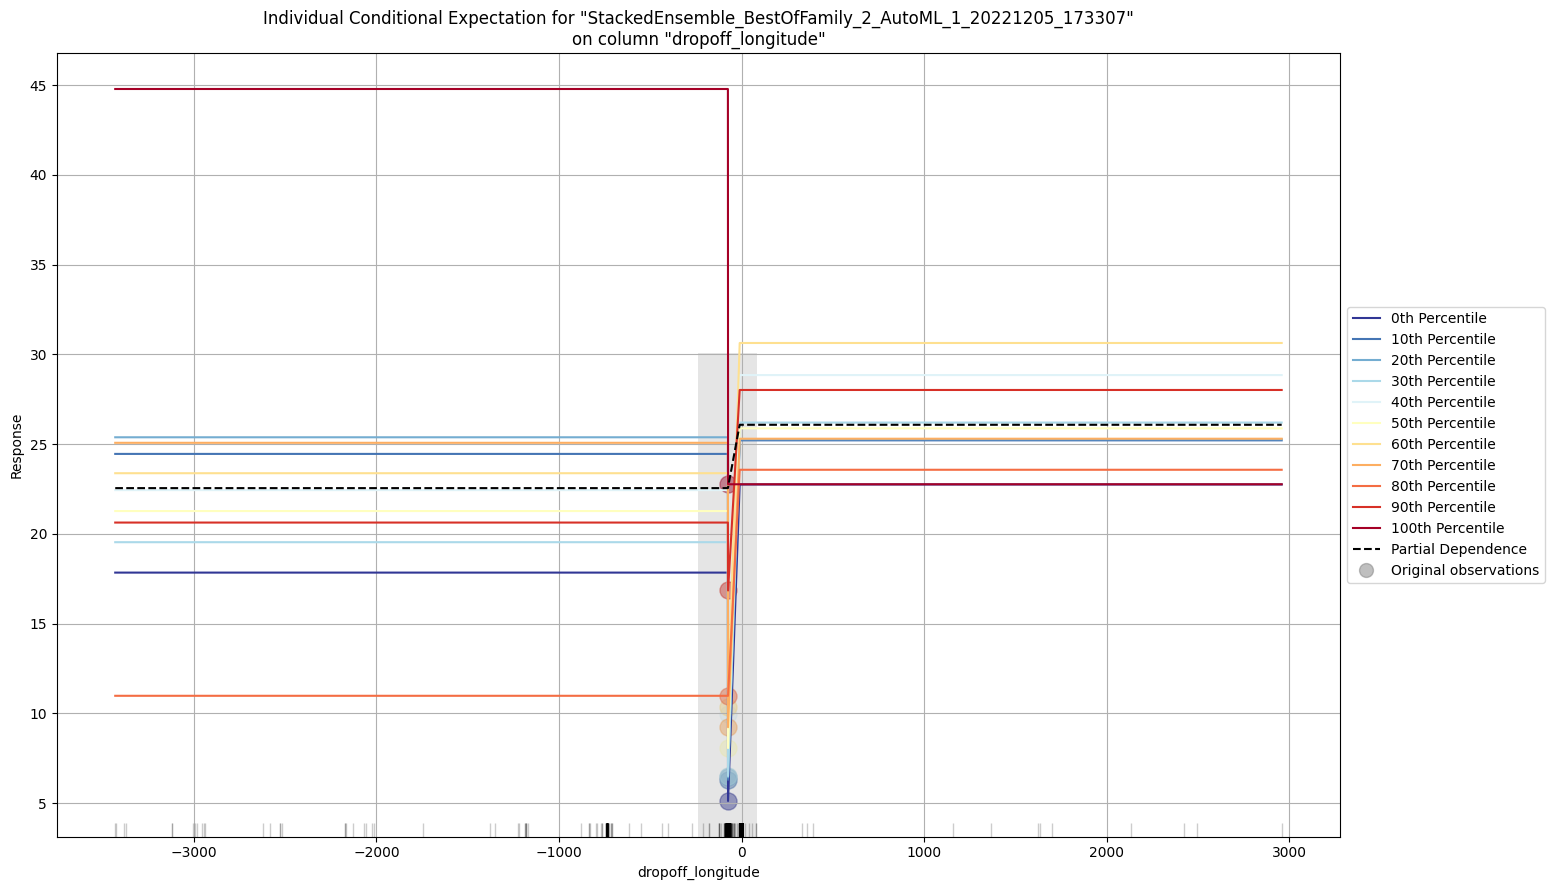

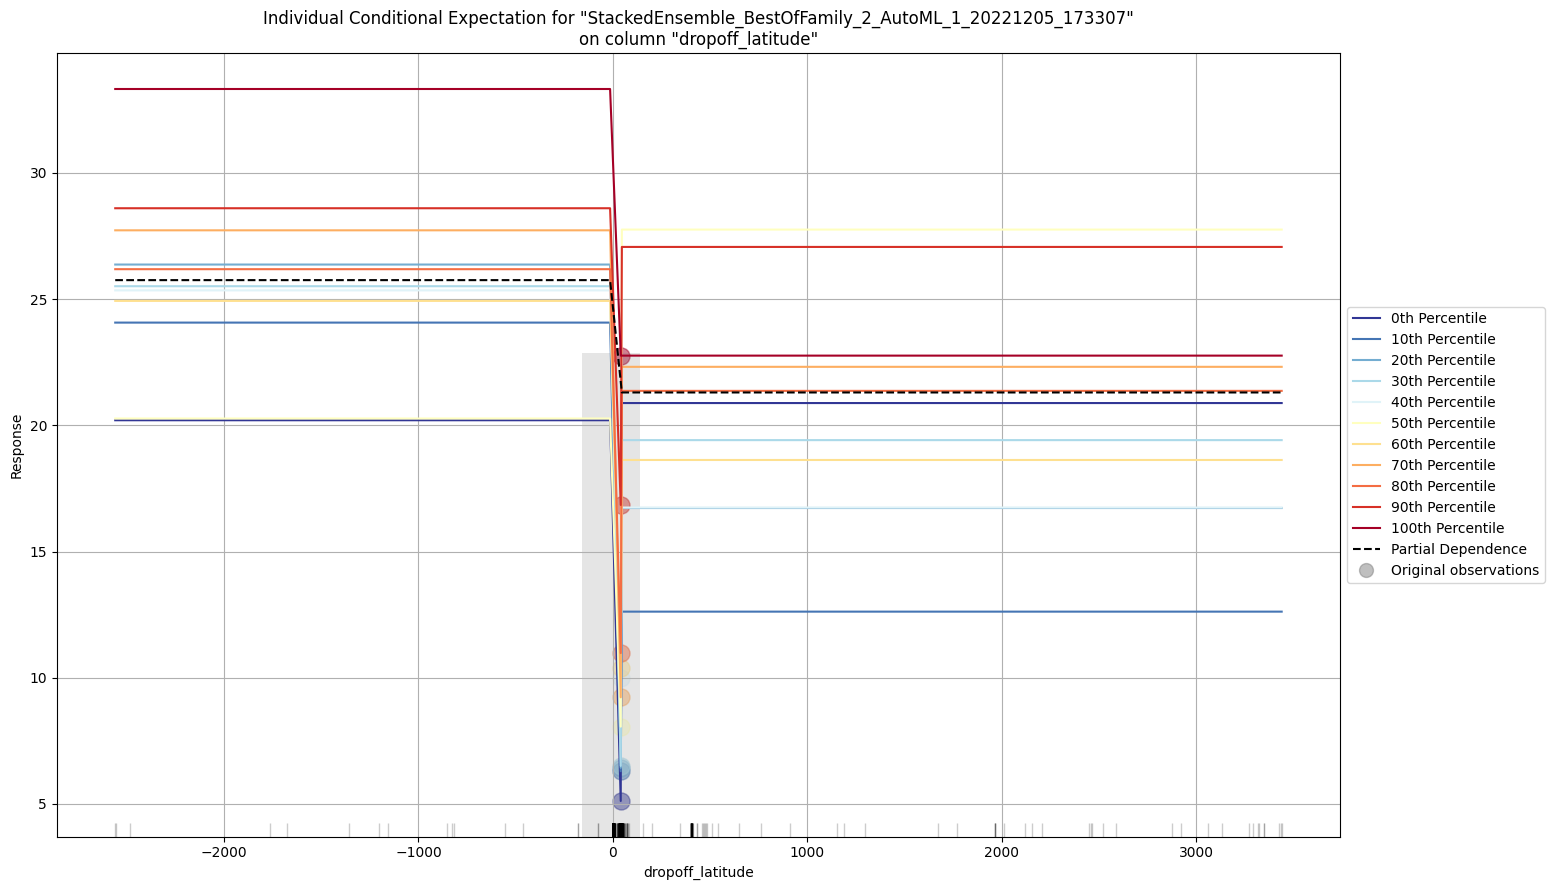

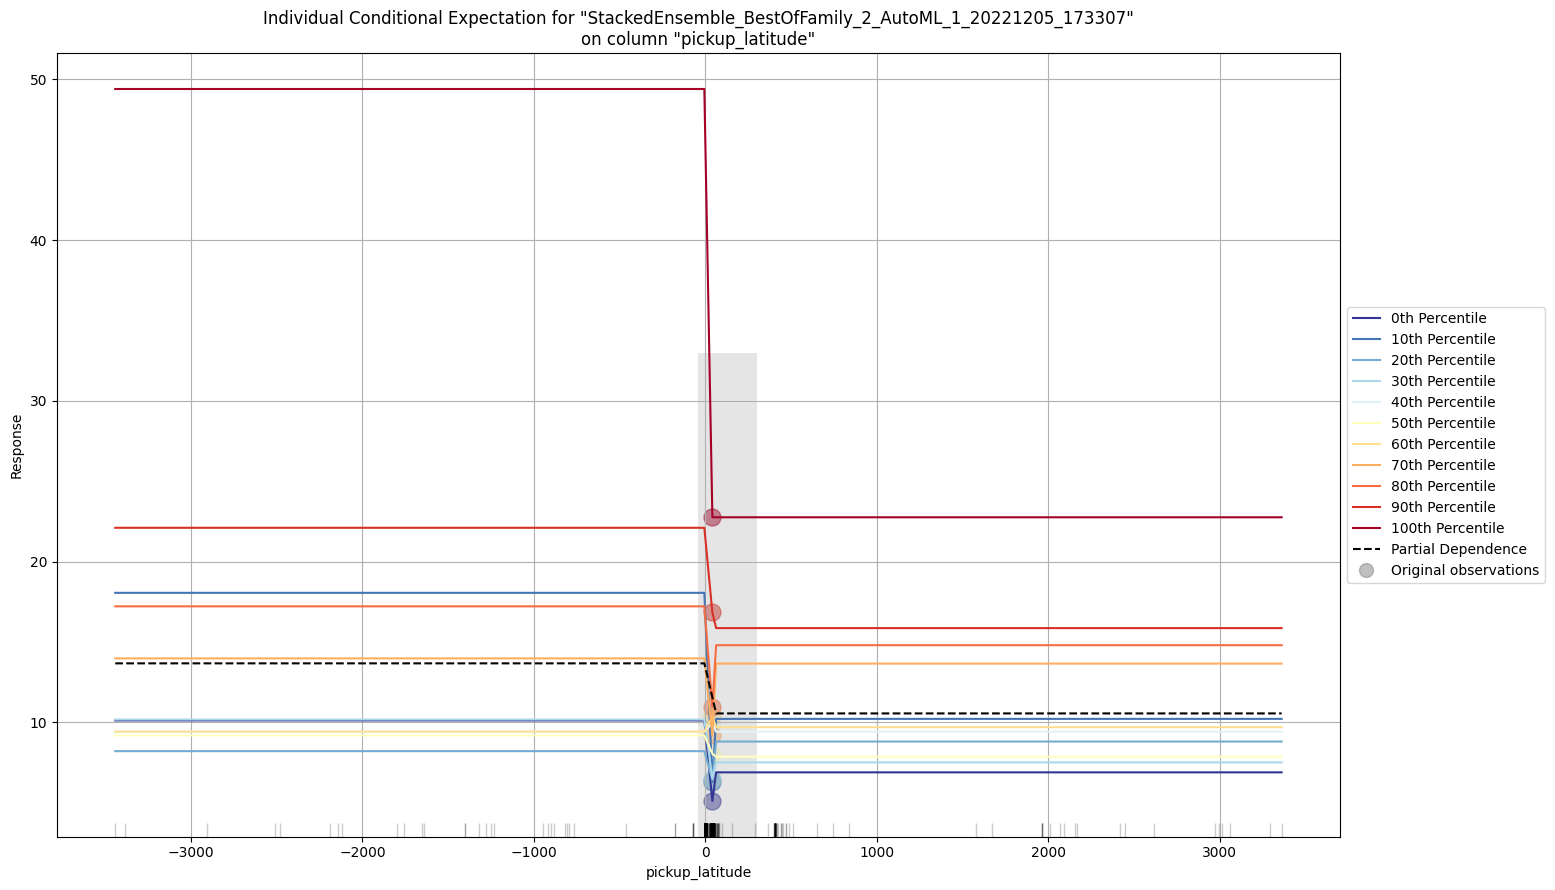

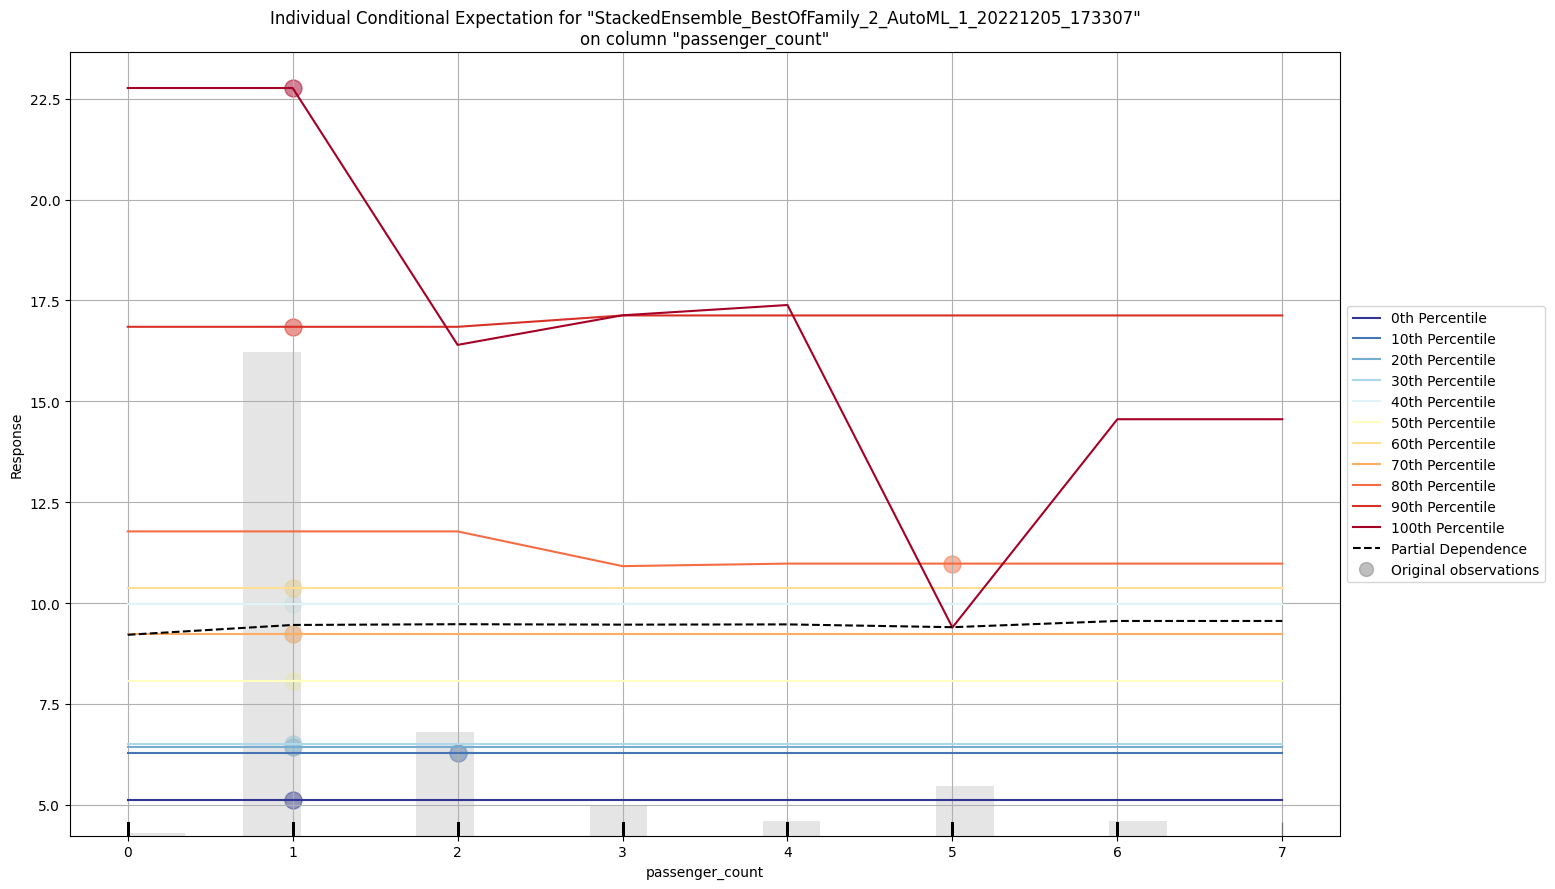



explain h2o_test_data took 2597.086396779865 sec


In [9]:
 with Timer("explain h2o_test_data"):
    aml.explain(h2o_test_data)

# Backup

In [5]:
data.summary()

/tmp/ipykernel_162380/605889900.py:1: H2ODeprecationWarning: ``summary()`` is deprecated, please use ``show_summary()`` or ``get_summary()`` instead
  data.summary()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
type,time,real,string,real,real,real,real,int
mins,1230768027000.0,-300.0,NaN,-3442.059565,-3492.263768,-3442.024565,-3547.886698,0.0
mean,1332289129821.6658,11.345045601662932,NaN,-72.509684443588,39.919791786888425,-72.51120972971923,39.92068144482933,1.6853799201556823
maxs,1435708794000.0,93963.36,NaN,3457.625683,3408.789565,3457.62235,3537.132528,208.0
sigma,58317921008.69085,20.71083219823222,NaN,12.848883381402695,9.642353041994898,12.782196517830833,9.633345796415139,1.3276643570959694
zeros,0,1380,0,1055693,1052158,1052745,1049666,195416
missing,0,0,0,0,0,376,376,0
0,2009-06-15 17:26:21,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1.0
1,2010-01-05 16:52:16,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,2011-08-18 00:35:00,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2.0
